In [1]:
from glob import glob
import os
import sys
import json
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import integrate, signal, fftpack
from functools import reduce
import mplcursors

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    find_nearest_ind, get_events_wdict, get_evoked_traces, qualitycheck_trials)

In [5]:
%matplotlib notebook

## Functions

In [6]:
### NEW FUNCTION test ###
def good_trials_from_epochs(data_traces, trace_ts):
    CH_FRACTION_THRESH = 0.3 # if less than 1/3 of chs exceed the DIFF_THRESH, it is considered a good trial
    TRIAL_RMS_THRESH = 200.0
    SHORT_WINDOW = [0.001, 0.005] # looking in window from 2 to 5 ms for high voltage difference (response-baseline)
    DIFF_THRESH = 200.0 # uV
    V_MAX = 1000.0 # uV
    HIGHSAMPLES_THRESH = 10 # number of samples above V_MAX
    
    ## RMS of baseline signal ##
    full_baseline_inds = trace_ts < -0.005 # 5 ms before stim delivery
    baseline_rms = np.power(np.mean(np.power(data_traces[full_baseline_inds, :, :].astype('float32'), 2), 0), 0.5)
    GOOD_BASELINE = np.mean(baseline_rms > TRIAL_RMS_THRESH, axis=0) < CH_FRACTION_THRESH
    
    ## Response - baseline voltage diff ##
    short_baseline_inds = np.nonzero((trace_ts > -SHORT_WINDOW[1]) & (trace_ts < -SHORT_WINDOW[0]))[0]
    short_response_inds = np.nonzero((trace_ts > SHORT_WINDOW[0]) & (trace_ts < SHORT_WINDOW[1]))[0]
    voltage_diff = np.abs(
        np.mean(data_traces[short_response_inds,:,:], axis=0) - np.mean(data_traces[short_baseline_inds,:,:], axis=0)
    )
    GOOD_RESPONSE = np.mean(voltage_diff > DIFF_THRESH, axis=0) < CH_FRACTION_THRESH
    
    ## Max voltage threshold ##
    longinds = np.nonzero((trace_ts < -0.05) | (trace_ts > 0.05))[0]
#     abs_voltage_max = np.max(np.abs(data_traces[longinds, :]), axis=0)
    numsamples_high = np.sum(np.abs(data_traces[longinds]) > V_MAX, axis=0)
    GOOD_HIGH = np.mean(numsamples_high > HIGHSAMPLES_THRESH, axis=0) < CH_FRACTION_THRESH
    
    ## Good trials, must be good in all categories ##
    return GOOD_BASELINE * GOOD_RESPONSE * GOOD_HIGH

#### Plot electrodes

In [7]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EEG_signal_quality'

In [8]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subjects .csv

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_06.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})
subject_df.head()

exp_type   mouse                          experiment sweep_states  \
0  urethane  582386        urethane_2021-07-15_11-36-58     urethane   
1  urethane  638703  urethane_estim_2022-10-14_12-25-20     urethane   
2  urethane  654181    urethane_vis_2022-11-23_08-30-16     urethane   
3  urethane  654182    urethane_vis_2022-12-02_11-02-25     urethane   
4  urethane  631037        urethane_2022-12-07_10-34-51     urethane   

           bad_chs  analyze  CCF_res notes  
0            0,2,3     True       10   NaN  
1  0,3,4,6,7,11,13     True       25   NaN  
2        7,8,11,13     True       25   NaN  
3     3,6,14,22,23     True       25   NaN  
4         6,7,8,21     True       25   NaN

In [10]:
subject_df.tail()

exp_type   mouse                    experiment      sweep_states  \
60    urethane  720762  urethane_2024-02-23_11-35-21          urethane   
61  psilocybin  724057    aw_psi_2024-04-04_10-35-18  awake,psilocybin   
62  ketanserin  730913    aw_ket_2024-04-26_10-11-34  awake,ketanserin   
63  ketanserin  730911    aw_ket_2024-05-02_10-41-41  awake,ketanserin   
64  ketanserin  735049    aw_ket_2024-05-23_11-42-08  awake,ketanserin   

            bad_chs  analyze  CCF_res      notes  
60        6,7,14,23     True       35        NaN  
61    0,1,4,6,13,29    False       36  DBA mouse  
62           0,3,13     True       37        NaN  
63  3,9,10,11,20,23     True       38        NaN  
64          3,12,29     True       39        NaN

# Test for single subject

In [11]:
subrow = subject_df.iloc[39]
print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))

703063 - psilocybin exp


Load experiment instance and EEG data

In [12]:
dfolder = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]

Experiment type: electrical and sensory stimulation


In [13]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])
print(exp.ephys_params['EEG']['sample_rate'])

2500


Find meta data from shared excel file

In [14]:
if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

Get bad channels list from meta data

In [29]:
if subrow['bad_chs'] == 'all':
    bad_chs = eeg_chs
    GOOD_CHS = []
else:
    badchstr = subrow['bad_chs'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
    GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [17]:
stim_log = pd.read_csv(exp.stimulus_log_file)

In [18]:
stim_log.head()

stim_type parameter      onset     offset  duration  sweep  good  \
0  biphasic        25  762.49153  762.49193    0.0004      0  True   
1  biphasic        25  769.07749  769.07789    0.0004      0  True   
2  biphasic        35  775.84042  775.84082    0.0004      0  True   
3  biphasic        15  783.14188  783.14228    0.0004      0  True   
4  biphasic        15  789.67154  789.67194    0.0004      0  True   

   mean_speed  resting_trial  
0    5.861954          False  
1    0.045559          False  
2    0.000000           True  
3    0.303728          False  
4    0.098712          False

In [19]:
num_sweeps = len(np.unique(stim_log['sweep'].values))
num_estims = np.sum(stim_log['stim_type'].values == 'biphasic')
num_currents = len(np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values))

Get injection times, if they exist.

In [20]:
try:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    print(inj_times)
except:
    inj_times = None
    print('No injection times for this {} experiment.'.format(subrow.exp_type))

[3257.421187, 4012.190062]


Mask the estim artifact

In [21]:
mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
    val = find_nearest_ind(eeg_ts, etime) - 2
    eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]

Load running

In [22]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

Load pupil

In [23]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

    ## Smooth eye diameter ##
    smooth_eyeD = np.zeros_like(eyeD)
    k = 50 # filter window is actually k*2+1
    for i in range(k, len(eyeD)-k-1):
        smooth_eyeD[i] = np.mean(eyeD[i-k:i+k]) # each point is the average of k surrounding points
    smooth_eyeD[:k] = eyeD[:k]
    smooth_eyeD[-k-1:] = eyeD[-k-1:]

    normpupil = pupilD / smooth_eyeD
else:
    print('No local Pupileye*.csv file. Check server.')
    normpupil = None

<IPython.core.display.Javascript object>


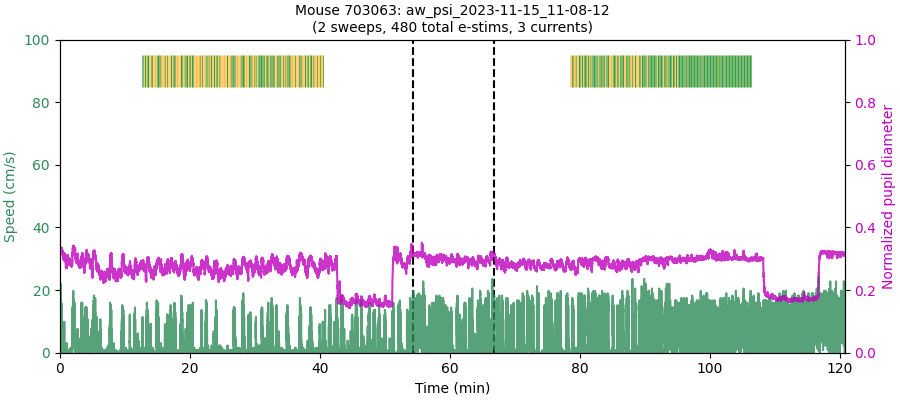

Text(0.5, 1.0, 'Mouse 703063: aw_psi_2023-11-15_11-08-12\n(2 sweeps, 480 total e-stims, 3 currents)')

In [24]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='k', linestyle='dashed')

ax.plot(speedts/60, speed, 'seagreen', alpha=0.8)
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')
ax.set_ylim([0, 100])

ax2 = ax.twinx()
if normpupil is not None:
    ax2.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    ax2.set_ylabel('Normalized pupil diameter', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
ax2.set_ylim([0, 1])

## add stim times to plot ##
# for etype, ecol in zip(['biphasic', 'circle'], ['orange', 'blue']):
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    ax2.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)
    
ax.set_title(
    'Mouse {}: {}\n({:d} sweeps, {:d} total e-stims, {:d} currents)'.format(
        subrow.mouse, subrow.experiment, num_sweeps, num_estims, num_currents))

Voltage histogram

In [25]:
Vbins = np.linspace(-6400, 6400, num=100)
Vhist = np.zeros((len(Vbins)-1, len(eeg_chs)), dtype=int)
for chi in eeg_chs:
    Vhist[:,chi], vbini = np.histogram(eeg_data[:, chi], bins=Vbins)

<IPython.core.display.Javascript object>


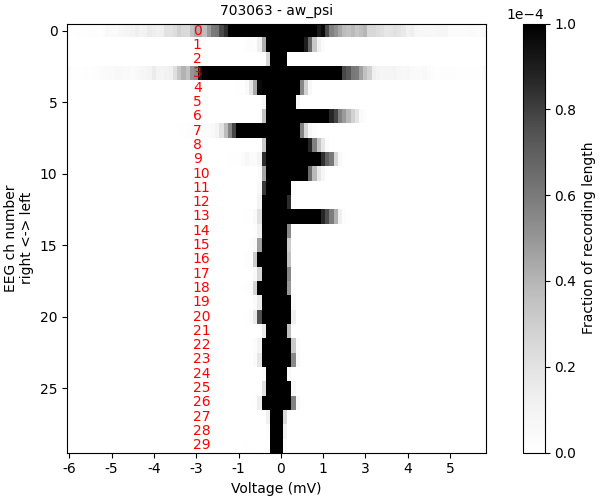

In [38]:
fig2, ax2 = plt.subplots(figsize=(6,5), constrained_layout=True)

hplot = ax2.imshow(Vhist.T / eeg_data.shape[0], cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=0.0001)
ax2.set_ylabel('EEG ch number\nright <-> left')
tt = np.arange(0, len(Vbins), 10)
ax2.set_xticks(tt)
ax2.set_xticklabels(np.round(Vbins[tt] / 1000).astype(int))
ax2.set_xlabel('Voltage (mV)')
ax2.set_title('{} - {}'.format(exp.mouse, exp_tag))
cbar = fig2.colorbar(hplot)
cbar.ax.set_ylabel('Fraction of recording length')

for bchi in bad_chs:
    ax2.annotate(str(bchi), color='r', xy=(0.3, 1-bchi/len(eeg_chs)), xycoords='axes fraction', va='top')

## Save ##
figname = '{}_{}_EEG_vhist.png'.format(exp.mouse, exp_tag)
# fig2.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

Spectrogram

In [27]:
frex, Pxx = signal.welch(
    eeg_data[:int(600. * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 10 min
    exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
)

<IPython.core.display.Javascript object>


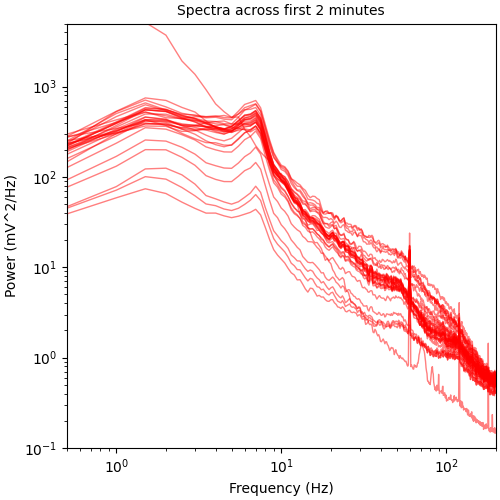

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [35]:
frinds = frex < 200

fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eeg_chs:
    if chi in bad_chs:
        linecol = 'r'
    else:
        linecol = 'gray'
    ax.loglog(frex[frinds], Pxx[frinds, chi], color=linecol, linewidth=1, alpha=0.5)
if len(GOOD_CHS) > 0:
    ax.loglog(frex[frinds], np.median(Pxx[:, GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)

ax.set_xlim([0.5, 200])
ax.set_ylim([0.1, 5000])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')

Plot whole recording

<IPython.core.display.Javascript object>


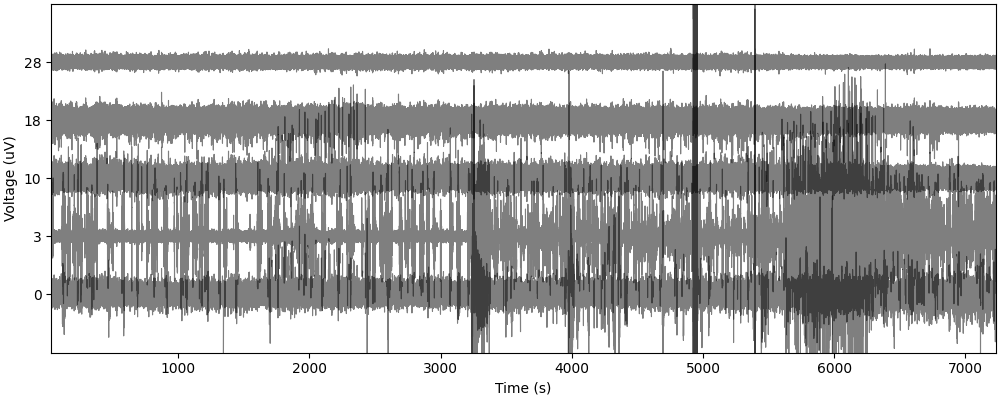

(-1000.0, 5000.0)

In [43]:
plot_chs = [0, 3, 10, 18, 28]
sep = 1000

fig0, ax0 = plt.subplots(figsize=(10,4), constrained_layout=True)

for ii, chi in enumerate(plot_chs):
    ax0.plot(eeg_ts, eeg_data[:, chi] + (ii * sep), 'k', linewidth=0.8, alpha=0.5)

ax0.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Voltage (uV)')
ax0.set_yticks(np.arange(len(plot_chs)) * sep)
ax0.set_yticklabels(plot_chs)
ax0.set_ylim([-sep, (ii + 1) * sep])

### Make the combo plot

### Get evoked traces

In [19]:
plot_win = [-1.0, 1.0] # epoch time
all_event_times = stim_log.onset.values
all_EP_traces, event_ts = get_evoked_traces(
    eeg_data, eeg_ts, all_event_times, np.abs(plot_win[0]), plot_win[1], exp.ephys_params['EEG']['sample_rate']
)

In [20]:
## Apply common-average reference ##
CAR_EP_traces = all_EP_traces - np.mean(all_EP_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

In [21]:
stim_log.head()

stim_type  parameter  duration      onset     offset  sweep  good  \
0  biphasic         20    0.0004  776.38894  776.38934      0  True   
1  biphasic         20    0.0004  782.97489  782.97529      0  True   
2  biphasic         30    0.0004  789.73781  789.73821      0  True   
3  biphasic         10    0.0004  797.03927  797.03967      0  True   
4  biphasic         10    0.0004  803.56892  803.56932      0  True   

   mean_speed  resting_trial  
0   21.663414          False  
1    2.202029          False  
2   14.191700          False  
3   26.059879          False  
4   26.021913          False

In [22]:
event_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': 20, 'sweep': 0}, out='index')
good_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': 20, 'sweep': 0, 'good': True}, out='index')
print(len(event_inds))
print(len(good_inds))
bad_inds = np.array([x for x in event_inds if x not in good_inds])

80
80


<IPython.core.display.Javascript object>


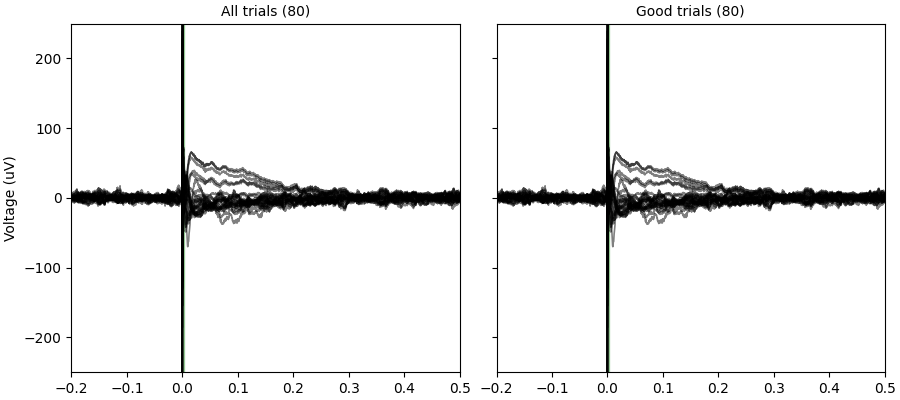

In [23]:
fig3, ax3 = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True, sharex=True, sharey=True)

event_avg = np.mean(CAR_EP_traces[:, :, event_inds], axis=2)
good_avg = np.mean(CAR_EP_traces[:, :, good_inds], axis=2)

ax3[0].axvspan(0, 0.002, color='g', alpha=0.3)
ax3[0].plot(event_ts, event_avg[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
ax3[0].set_xlim([-0.2, 0.5])
ax3[0].set_ylim([-250, 250])
ax3[0].set_ylabel('Voltage (uV)')
ax3[0].set_title('All trials ({:d})'.format(len(event_inds)))

ax3[1].axvspan(0, 0.002, color='g', alpha=0.3)
ax3[1].plot(event_ts, good_avg[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
ax3[1].set_title('Good trials ({:d})'.format(len(good_inds)));

Plot a few single trials

<IPython.core.display.Javascript object>


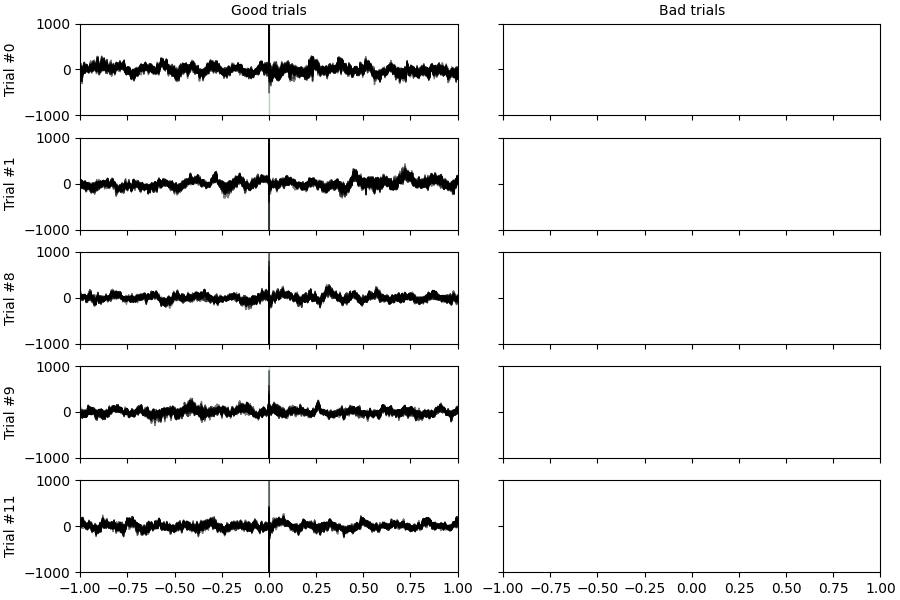

(-1000.0, 1000.0)

In [24]:
pnumtrials = 5
plot_window = [-1.0, 1.0] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

fig4, ax4 = plt.subplots(pnumtrials, 2, figsize=(9,6), constrained_layout=True, sharex=True, sharey=True)

for ii in range(pnumtrials):
    ## GOOD ##
    ax4[ii,0].axvspan(0, 0.002, color='g', alpha=0.3)
    ax4[ii,0].plot(event_ts, ptraces[:, GOOD_CHS, good_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
    ax4[ii,0].set_ylabel('Trial #{:d}'.format(good_inds[ii]))
    ## BAD ##
#     ax4[ii,1].axvspan(0, 0.002, color='g', alpha=0.3)
#     ax4[ii,1].plot(event_ts, ptraces[:, GOOD_CHS, bad_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
#     ax4[ii,1].set_ylabel('Trial #{:d}'.format(bad_inds[ii]))
    
    if ii == 0:
        ax4[ii,0].set_title('Good trials')
        ax4[ii,1].set_title('Bad trials')

ax4[ii,0].set_xlim(plot_window)
ax4[ii,0].set_ylim([-1000, 1000])

# Investigating EP quality metrics

In [25]:
abs_max_voltage = np.max(np.abs(all_EP_traces), axis=0)
print(abs_max_voltage.shape)

(30, 480)


<IPython.core.display.Javascript object>


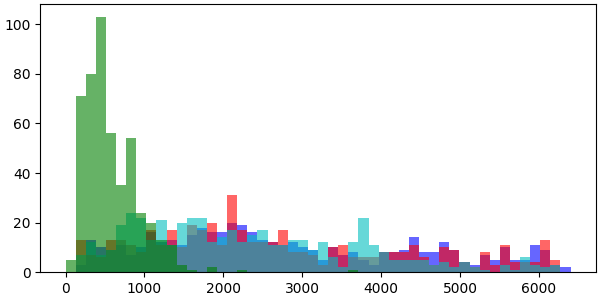

(array([  5.,  71.,  80., 103.,  56.,  35.,  54.,  24.,  20.,  13.,  11.,
          3.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,  128.,  256.,  384.,  512.,  640.,  768.,  896., 1024.,
        1152., 1280., 1408., 1536., 1664., 1792., 1920., 2048., 2176.,
        2304., 2432., 2560., 2688., 2816., 2944., 3072., 3200., 3328.,
        3456., 3584., 3712., 3840., 3968., 4096., 4224., 4352., 4480.,
        4608., 4736., 4864., 4992., 5120., 5248., 5376., 5504., 5632.,
        5760., 5888., 6016., 6144., 6272., 6400.]),
 <BarContainer object of 50 artists>)

In [26]:
testchs = [0, 3, 7, 29]

fig5, ax5 = plt.subplots(figsize=(6,3), constrained_layout=True)

ax5.hist(abs_max_voltage[testchs[0], :], bins=50, range=(0, 6400), color='b', alpha=0.6)
ax5.hist(abs_max_voltage[testchs[1], :], bins=50, range=(0, 6400), color='r', alpha=0.6)
ax5.hist(abs_max_voltage[testchs[2], :], bins=50, range=(0, 6400), color='c', alpha=0.6)
ax5.hist(abs_max_voltage[testchs[3], :], bins=50, range=(0, 6400), color='g', alpha=0.6)

# ax5.set_ylim([0, 500])

In [27]:
abs_max_voltage = np.max(np.abs(all_EP_traces), axis=0)
print(abs_max_voltage.shape)

(30, 480)


### Baseline RMS

In [28]:
baseline_inds = event_ts < -0.005
baseline_rms = np.power(np.mean(np.power(all_EP_traces[baseline_inds, :, :].astype('float32'), 2), 0), 0.5)

In [29]:
baseline_rms.shape

(30, 480)

<IPython.core.display.Javascript object>


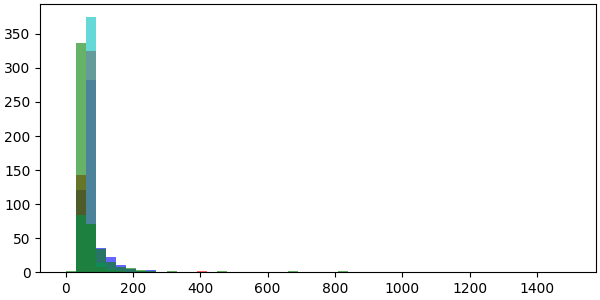

(array([  2., 337.,  71.,  34.,  15.,   7.,   6.,   3.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
        1080., 1110., 1140., 1170., 1200., 1230., 1260., 1290., 1320.,
        1350., 1380., 1410., 1440., 1470., 1500.], dtype=float32),
 <BarContainer object of 50 artists>)

In [30]:
testchs = [0, 3, 7, 29]

fig5, ax6 = plt.subplots(figsize=(6,3), constrained_layout=True)

ax6.hist(baseline_rms[testchs[0], :], bins=50, range=(0, 1500), color='b', alpha=0.6)
ax6.hist(baseline_rms[testchs[1], :], bins=50, range=(0, 1500), color='r', alpha=0.6)
ax6.hist(baseline_rms[testchs[2], :], bins=50, range=(0, 1500), color='c', alpha=0.6)
ax6.hist(baseline_rms[testchs[3], :], bins=50, range=(0, 1500), color='g', alpha=0.6)

In [47]:
TRIAL_RMS_THRESH = 200.0

In [48]:
trial_med_rms = np.median(baseline_rms, axis=0)
trial_mean_rms = np.mean(baseline_rms, axis=0)
trial_ch_fraction = np.mean(baseline_rms > TRIAL_RMS_THRESH, axis=0)
BAD_BASELINE = trial_ch_fraction > 0.33

<IPython.core.display.Javascript object>


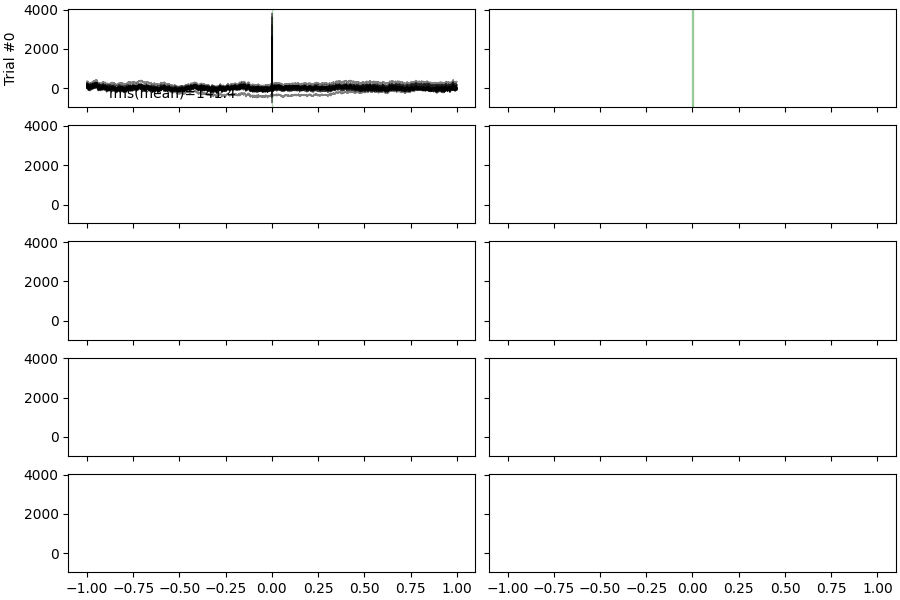

IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
pnumtrials = 5
plot_window = [-1.0, 1.0] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

fig4, ax4 = plt.subplots(pnumtrials, 2, figsize=(9,6), constrained_layout=True, sharex=True, sharey=True)

for ii in range(pnumtrials):
    ## GOOD ##
    ax4[ii,0].axvspan(0, 0.002, color='g', alpha=0.3)
    ax4[ii,0].plot(event_ts, ptraces[:, GOOD_CHS, good_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
    ax4[ii,0].set_ylabel('Trial #{:d}'.format(good_inds[ii]))
#     ax4[ii,0].annotate('rms(med)={:.1f}'.format(trial_med_rms[good_inds[ii]]), xy=(0.1, 0.8), xycoords='axes fraction')
    if BAD_BASELINE[good_inds[ii]]:
        tc = 'r'
    else:
        tc = 'k'
    ax4[ii,0].annotate(
        'rms(mean)={:.1f}'.format(trial_mean_rms[good_inds[ii]]), xy=(0.1, 0.1), xycoords='axes fraction', color=tc)
    
    ## BAD ##
    ax4[ii,1].axvspan(0, 0.002, color='g', alpha=0.3)
    ax4[ii,1].plot(event_ts, ptraces[:, GOOD_CHS, bad_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
    ax4[ii,1].set_ylabel('Trial #{:d}'.format(bad_inds[ii]))
#     ax4[ii,1].annotate('rms(med)={:.1f}'.format(trial_med_rms[bad_inds[ii]]), xy=(0.1, 0.8), xycoords='axes fraction')
    if BAD_BASELINE[bad_inds[ii]]:
        tc = 'r'
    else:
        tc = 'k'
    ax4[ii,1].annotate(
        'rms(mean)={:.1f}'.format(trial_mean_rms[bad_inds[ii]]), xy=(0.1, 0.1), xycoords='axes fraction', color=tc)
    
    if ii == 0:
        ax4[ii,0].set_title('Good trials')
        ax4[ii,1].set_title('Bad trials')

ax4[ii,0].set_xlim(plot_window)
ax4[ii,0].set_ylim([-1000, 1000])

### Response voltage

In [31]:
DIFF_THRESH = 200.0 # uV, original 200.0
SHORT_WINDOW = [0.001, 0.005] # original [0.001, 0.003]

In [32]:
short_baseline_inds = np.nonzero((event_ts > -SHORT_WINDOW[1]) & (event_ts < -SHORT_WINDOW[0]))[0]
short_response_inds = np.nonzero((event_ts > SHORT_WINDOW[0]) & (event_ts < SHORT_WINDOW[1]))[0]

In [33]:
voltage_diff = np.abs(
    np.mean(all_EP_traces[short_response_inds,:,:], axis=0) - np.mean(all_EP_traces[short_baseline_inds,:,:], axis=0)
)

<IPython.core.display.Javascript object>


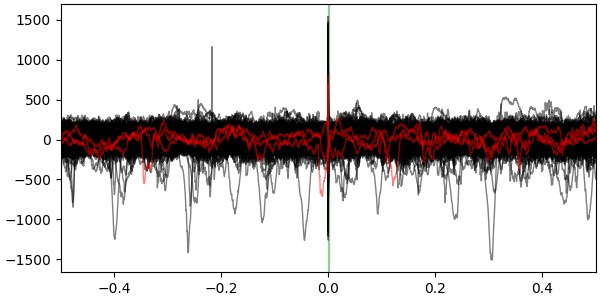

(-0.5, 0.5)

In [34]:
plch = 20
plot_window = [-0.5, 0.5] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

btrs = voltage_diff[plch,:] > DIFF_THRESH
gtrs = ~btrs
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(event_ts, ptraces[:, plch, gtrs], color='k', linewidth=1.0, alpha=0.5)
if np.sum(btrs) > 0:
    ax.plot(event_ts, ptraces[:, plch, btrs], color='r', linewidth=1.0, alpha=0.5)
ax.set_xlim(plot_window)

Not sure this is capturing much?

<IPython.core.display.Javascript object>


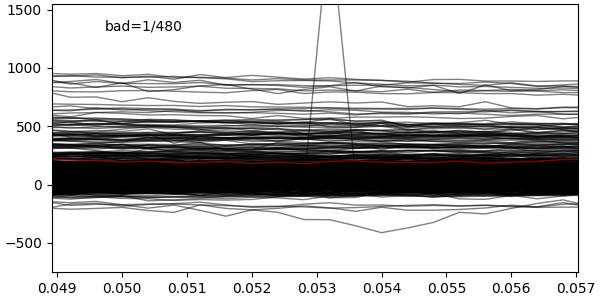

Text(0.1, 0.9, 'bad=1/480')

In [36]:
plch = 1
plot_window = [-0.5, 0.5] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

btrs = np.mean(voltage_diff > DIFF_THRESH, axis=0) > 0.33
gtrs = ~btrs
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(event_ts, ptraces[:, plch, gtrs], color='k', linewidth=1.0, alpha=0.5)
if np.sum(btrs) > 0:
    ax.plot(event_ts, ptraces[:, plch, btrs], color='r', linewidth=1.0, alpha=0.5)
ax.set_xlim(plot_window)
ax.annotate('bad={:d}/{:d}'.format(np.sum(btrs), len(btrs)), xy=(0.1, 0.9), xycoords='axes fraction')

### High overall voltages

In [37]:
V_MAX = 1000.0 # uV
HIGHSAMPLES_THRESH = 10 # number of samples above V_MAX
CH_THRESH = 0.30 # number of chs that meet HIGH V THRESH

In [38]:
longinds = np.nonzero((event_ts < -0.05) | (event_ts > 0.05))[0]
abs_voltage_max = np.max(np.abs(all_EP_traces[longinds]), axis=0)
gtrs2 = np.mean(abs_voltage_max > V_MAX, axis=0) < CH_THRESH

numsamples_high = np.sum(np.abs(all_EP_traces[longinds]) > V_MAX, axis=0)
gtrs3 = np.mean(numsamples_high > HIGHSAMPLES_THRESH, axis=0) < CH_THRESH

In [39]:
btrs3 = np.mean(numsamples_high > HIGHSAMPLES_THRESH, axis=0) > CH_THRESH
print(np.sum(btrs3))
print(btrs3[:10])

0
[False False False False False False False False False False]


In [40]:
print(np.sum(gtrs3))
print(gtrs3[:10])

480
[ True  True  True  True  True  True  True  True  True  True]


<IPython.core.display.Javascript object>


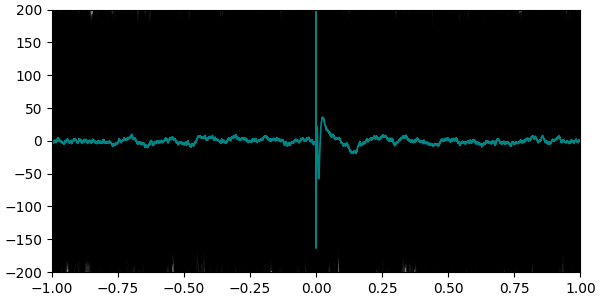

(-200.0, 200.0)

In [41]:
plch = 16
plot_window = [-1.0, 1.0] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

gtrs1 = abs_voltage_max[plch,:] < V_MAX

gtrs = gtrs3
btrs = ~gtrs
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(event_ts, ptraces[:, plch, gtrs], color='k', linewidth=1.0, alpha=0.5)
# if np.sum(btrs) > 0:
#     ax.plot(event_ts, ptraces[:, plch, btrs], color='r', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(ptraces[:, plch, gtrs], axis=1), color='c', linewidth=1.2, alpha=0.7)
ax.set_xlim(plot_window)
ax.annotate('bad trials={:d}/{:d}'.format(np.sum(btrs), ptraces.shape[2]), xy=(0.1, 0.9), xycoords='axes fraction')
ax.set_ylim([-200, 200])

In [68]:
np.mean(ptraces[:, plch, gtrs], axis=1).shape

(5000,)

<IPython.core.display.Javascript object>


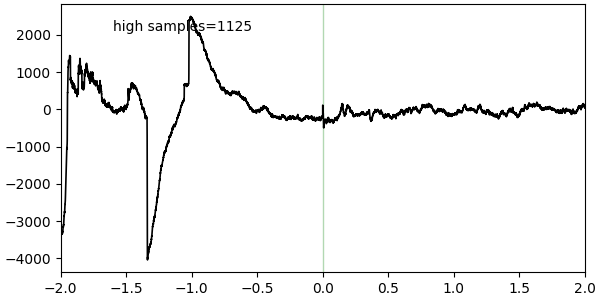

Text(0.1, 0.9, 'high samples=1125')

In [177]:
plch = 0
pltr = 8

testtrace = all_EP_traces[:, plch, pltr]
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(event_ts, testtrace, color='k', linewidth=1.2)
ax.set_xlim([-2.0, 2.0])
ax.annotate('high samples={:d}'.format(numsamples_high[plch, pltr]), xy=(0.1, 0.9), xycoords='axes fraction')

Test sample threshold

In [228]:
sampnumtest = np.arange(0, 500, 2)
badtrialcount = np.zeros(len(sampnumtest))
num_high = np.sum(np.abs(all_EP_traces[longinds]) > V_MAX, axis=0)

for ii, sampnumi in enumerate(sampnumtest):
    badtrialcount[ii] = np.sum(np.mean(num_high > sampnumi, axis=0) >= CH_THRESH)

<IPython.core.display.Javascript object>


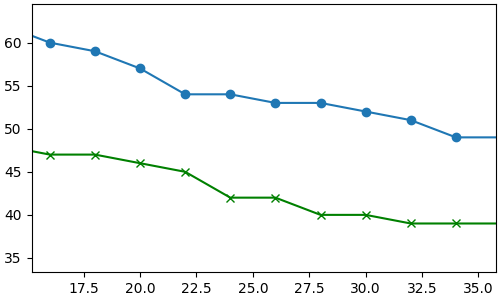

In [225]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
ax.plot(sampnumtest, badtrialcount, marker='o')

In [229]:
ax.plot(sampnumtest, badtrialcount, color='g', marker='x')

# TEST new quality function

In [50]:
stim_log['newgood'] = good_trials_from_epochs(all_EP_traces, event_ts)

In [51]:
stim_log.head()

stim_type parameter      onset     offset  duration  sweep  good  \
0  biphasic        25  782.45243  782.45283    0.0004      0  True   
1  biphasic        25  789.03839  789.03879    0.0004      0  True   
2  biphasic        35  795.80131  795.80171    0.0004      0  True   
3  biphasic        15  803.10278  803.10318    0.0004      0  True   
4  biphasic        15  809.63244  809.63284    0.0004      0  True   

   mean_speed  resting_trial  newgood  
0    3.561213          False     True  
1    1.275658          False     True  
2    0.000000           True     True  
3    0.000000           True     True  
4    1.146574          False     True

In [52]:
print(len(stim_log))
print(np.sum(stim_log['good']))
print(np.sum(stim_log['newgood']))

720
713
714


In [57]:
# event_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': 20, 'sweep': 0}, out='index')
# good_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': 20, 'sweep': 0, 'good': True}, out='index')
newgood_inds = get_events_wdict(stim_log, {'stim_type': 'biphasic', 'parameter': '25', 'sweep': 0, 'newgood': True}, out='index')
print(len(event_inds))
print(len(good_inds))
print(len(newgood_inds))
newbad_inds = np.array([x for x in event_inds if x not in newgood_inds])

80
80
80


<IPython.core.display.Javascript object>


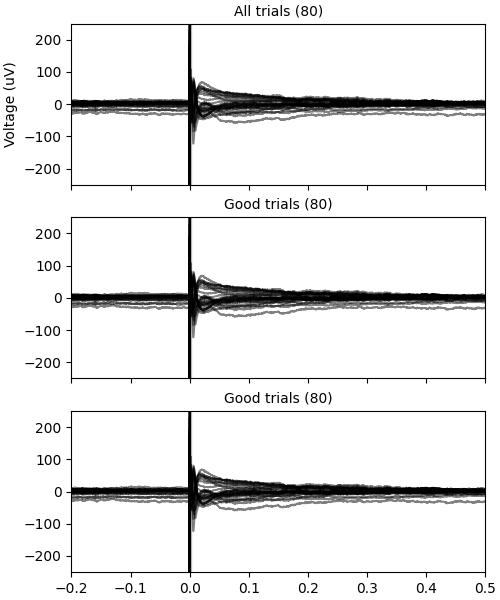

In [58]:
fig3, ax3 = plt.subplots(3, 1, figsize=(5,6), constrained_layout=True, sharex=True, sharey=True)

event_avg = np.mean(CAR_EP_traces[:, :, event_inds], axis=2)
good_avg = np.mean(CAR_EP_traces[:, :, good_inds], axis=2)
newgood_avg = np.mean(CAR_EP_traces[:, :, newgood_inds], axis=2)

ax3[0].axvspan(0, 0.002, color='g', alpha=0.3)
ax3[0].plot(event_ts, event_avg[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
ax3[0].set_xlim([-0.2, 0.5])
ax3[0].set_ylim([-250, 250])
ax3[0].set_ylabel('Voltage (uV)')
ax3[0].set_title('All trials ({:d})'.format(len(event_inds)))

ax3[1].axvspan(0, 0.002, color='g', alpha=0.3)
ax3[1].plot(event_ts, good_avg[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
ax3[1].set_title('Good trials ({:d})'.format(len(good_inds)));

ax3[2].axvspan(0, 0.002, color='g', alpha=0.3)
ax3[2].plot(event_ts, newgood_avg[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
ax3[2].set_title('Good trials ({:d})'.format(len(newgood_inds)));

<IPython.core.display.Javascript object>


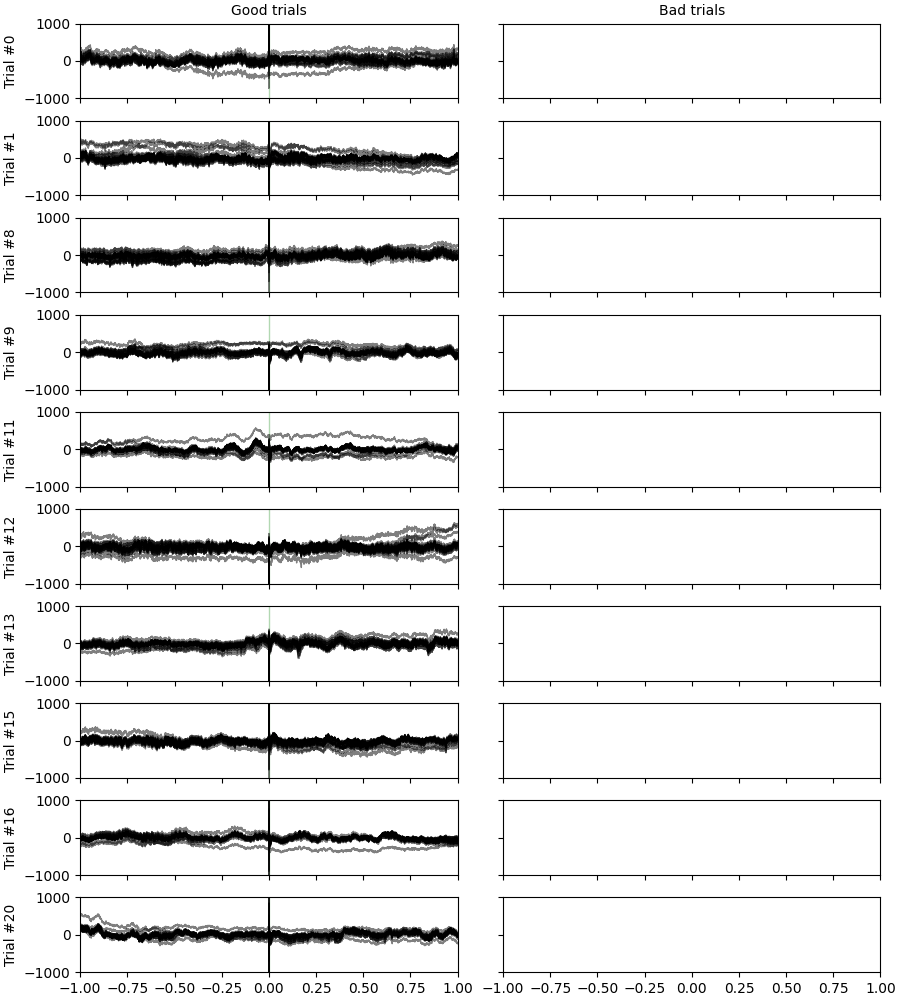

(-1000.0, 1000.0)

In [59]:
pnumtrials = 10
plot_window = [-1.0, 1.0] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

fig4, ax4 = plt.subplots(pnumtrials, 2, figsize=(9,10), constrained_layout=True, sharex=True, sharey=True)

for ii in range(pnumtrials):
    ## GOOD ##
    ax4[ii,0].axvspan(0, 0.002, color='g', alpha=0.3)
    ax4[ii,0].plot(event_ts, ptraces[:, GOOD_CHS, newgood_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
    ax4[ii,0].set_ylabel('Trial #{:d}'.format(newgood_inds[ii]))
    
    ## BAD ##
#     ax4[ii,1].axvspan(0, 0.002, color='g', alpha=0.3)
#     ax4[ii,1].plot(event_ts, ptraces[:, GOOD_CHS, newbad_inds[ii]], color='k', linewidth=1.0, alpha=0.5)
#     ax4[ii,1].set_ylabel('Trial #{:d}'.format(newbad_inds[ii]))
    
    if ii == 0:
        ax4[ii,0].set_title('Good trials')
        ax4[ii,1].set_title('Bad trials')

ax4[ii,0].set_xlim(plot_window)
ax4[ii,0].set_ylim([-1000, 1000])

<IPython.core.display.Javascript object>


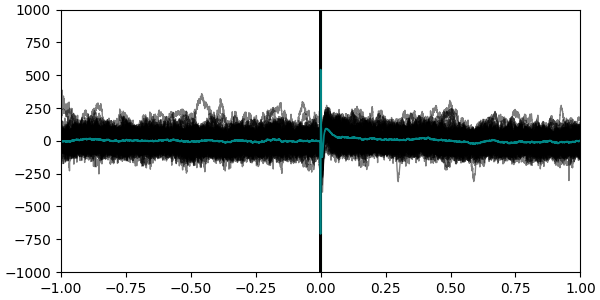

(-1000.0, 1000.0)

In [86]:
plch = 7
plot_window = [-1.0, 1.0] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(event_ts, ptraces[:, plch, newgood_inds], color='k', linewidth=1.0, alpha=0.5)
if np.sum(newbad_inds) > 0:
    ax.plot(event_ts, ptraces[:, plch, newbad_inds], color='r', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(ptraces[:, plch, newgood_inds], axis=1), color='c', linewidth=1.2, alpha=0.7)
ax.set_xlim(plot_window)
# ax.annotate('bad trials={:d}/{:d}'.format(np.sum(btrs), ptraces.shape[2]), xy=(0.1, 0.9), xycoords='axes fraction')
ax.set_ylim([-1000, 1000])

<IPython.core.display.Javascript object>


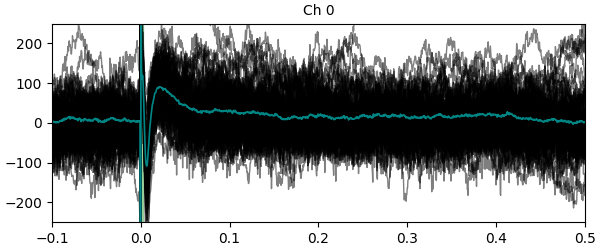

<IPython.core.display.Javascript object>


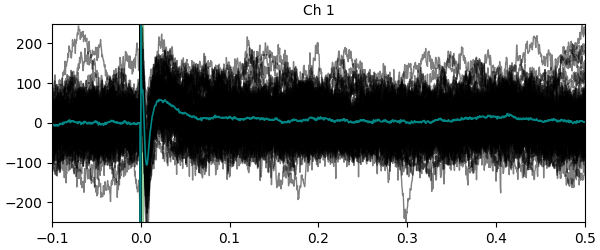

<IPython.core.display.Javascript object>


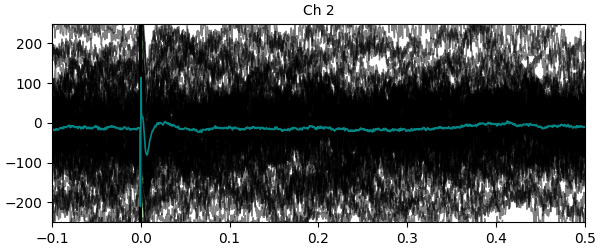

<IPython.core.display.Javascript object>


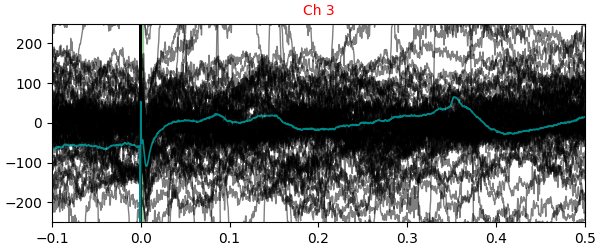

<IPython.core.display.Javascript object>


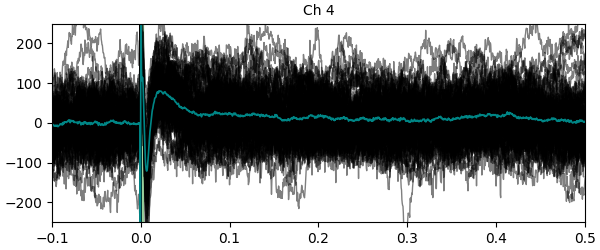

<IPython.core.display.Javascript object>


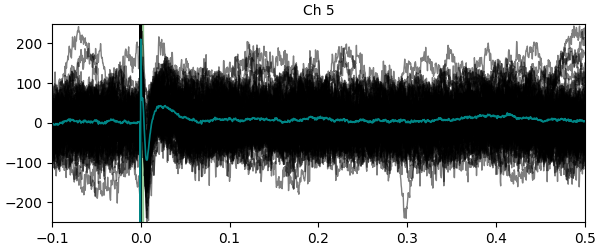

<IPython.core.display.Javascript object>


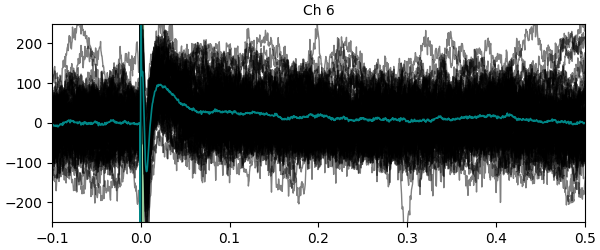

<IPython.core.display.Javascript object>


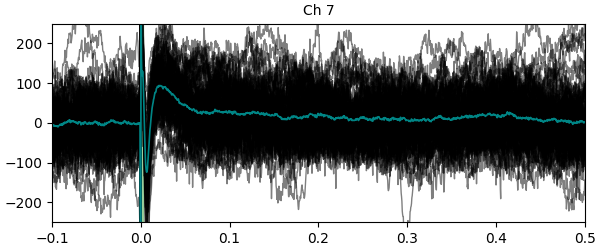

<IPython.core.display.Javascript object>


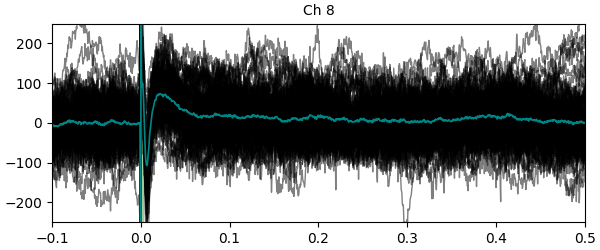

<IPython.core.display.Javascript object>


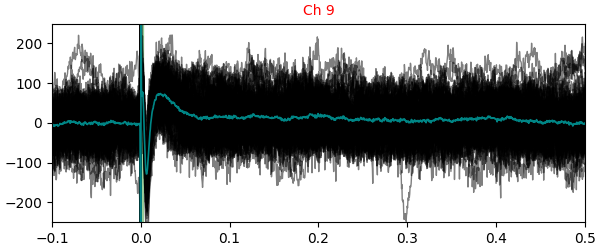

<IPython.core.display.Javascript object>


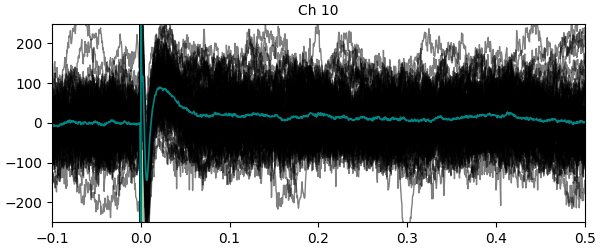

<IPython.core.display.Javascript object>


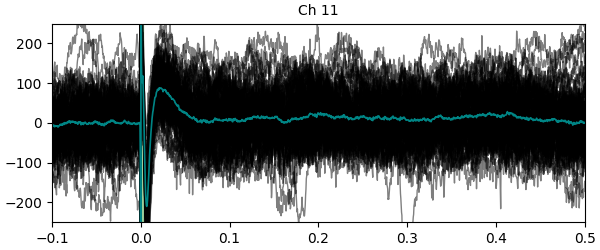

<IPython.core.display.Javascript object>


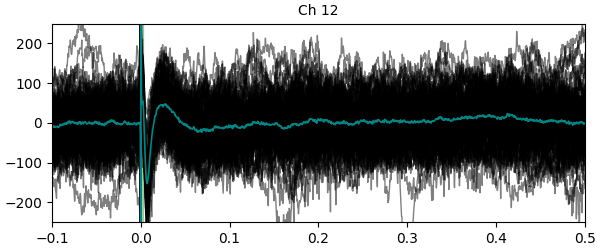

<IPython.core.display.Javascript object>


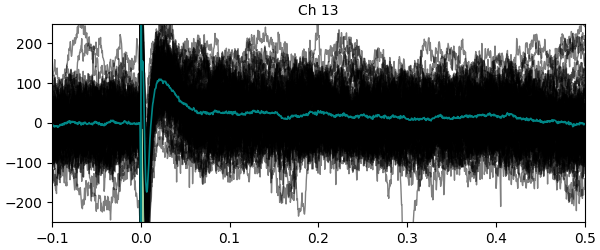

<IPython.core.display.Javascript object>


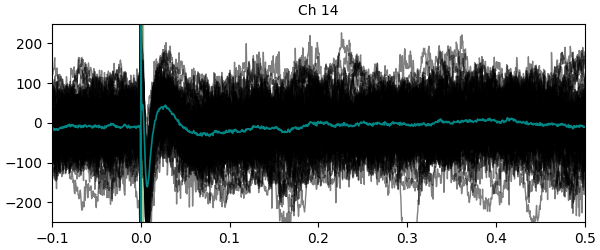

<IPython.core.display.Javascript object>


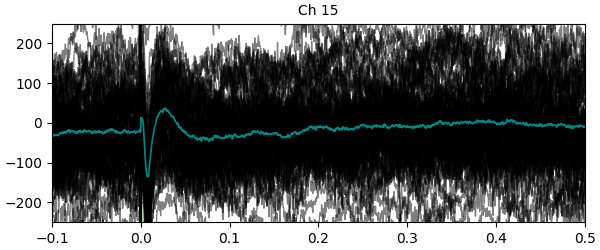

<IPython.core.display.Javascript object>


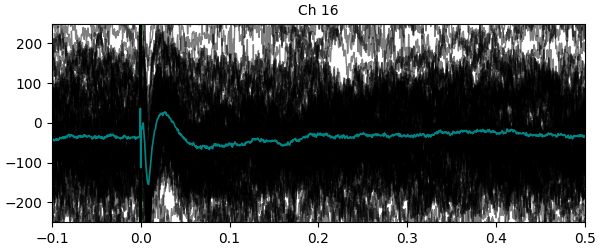

<IPython.core.display.Javascript object>


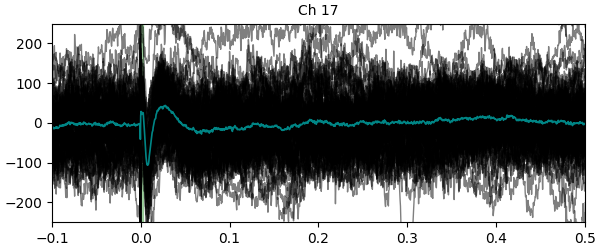

<IPython.core.display.Javascript object>


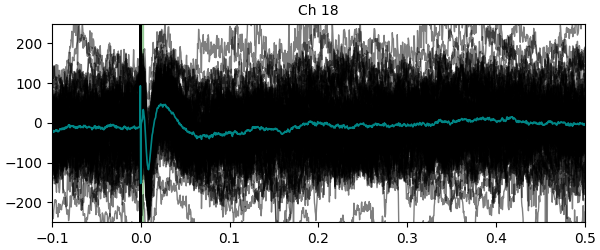

<IPython.core.display.Javascript object>


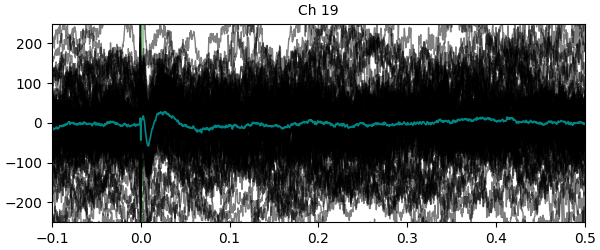

<IPython.core.display.Javascript object>


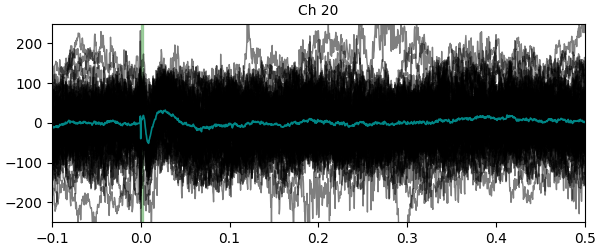

<IPython.core.display.Javascript object>


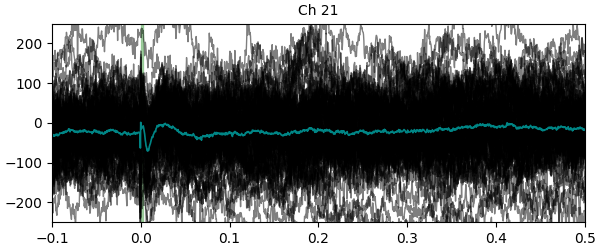

<IPython.core.display.Javascript object>


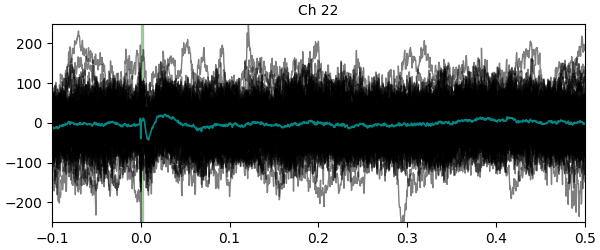

<IPython.core.display.Javascript object>


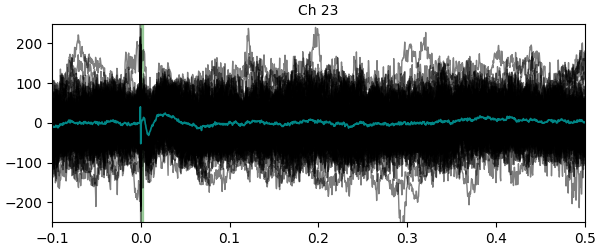

<IPython.core.display.Javascript object>


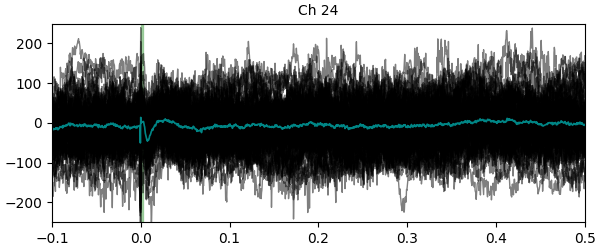

<IPython.core.display.Javascript object>


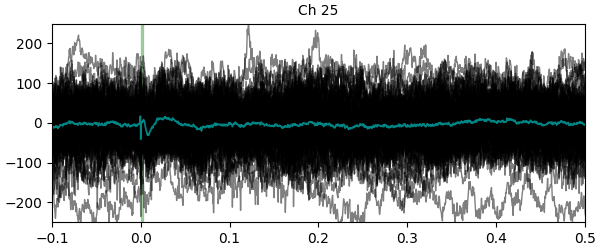

<IPython.core.display.Javascript object>


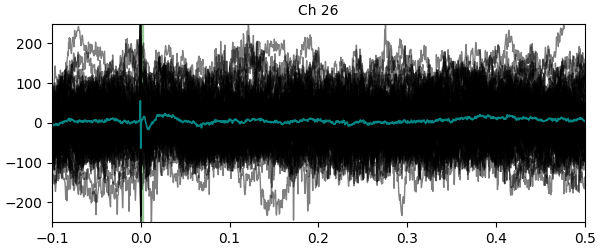

<IPython.core.display.Javascript object>


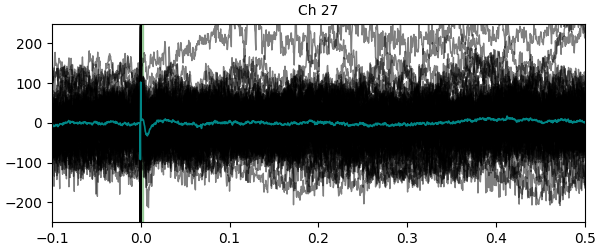

<IPython.core.display.Javascript object>


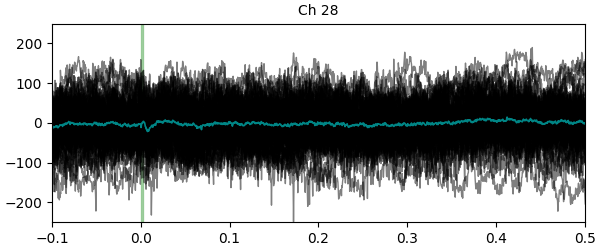

<IPython.core.display.Javascript object>


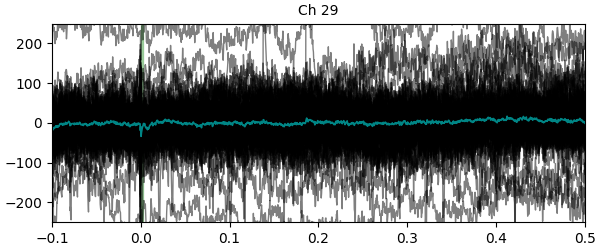

In [89]:
plot_window = [-0.1, 0.5] # [-0.2, 0.6] [-2.0, 2.0]
ptraces = all_EP_traces # all_EP_traces or CAR_EP_traces

for plch in eeg_chs:
    fig, ax = plt.subplots(figsize=(6,2.5), constrained_layout=True)
    ax.axvspan(0, 0.002, color='g', alpha=0.3)
    ax.plot(event_ts, ptraces[:, plch, newgood_inds], color='k', linewidth=1.0, alpha=0.5)
    if np.sum(newbad_inds) > 0:
        ax.plot(event_ts, ptraces[:, plch, newbad_inds], color='r', linewidth=1.0, alpha=0.5)
    ax.plot(event_ts, np.mean(ptraces[:, plch, newgood_inds], axis=1), color='c', linewidth=1.2, alpha=0.7)
    ax.set_xlim(plot_window)
    # ax.annotate('bad trials={:d}/{:d}'.format(np.sum(btrs), ptraces.shape[2]), xy=(0.1, 0.9), xycoords='axes fraction')
    ax.set_ylim([-250, 250])
    if plch in bad_chs:
        titlec = 'r'
    else:
        titlec = 'k'
    ax.set_title('Ch {:d}'.format(plch), color=titlec)